<a href="https://colab.research.google.com/github/Temmy-bit/Advance-Pytorch/blob/main/transfer_learning_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Hyperparameters
in_channel = 3
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5


train_dataset = datasets.CIFAR10(root='.',train=True,
                                      transform = transforms.ToTensor(),
                                      download = True)


test_dataset = datasets.CIFAR10(root='.',train=False,
                                      transform = transforms.ToTensor(),
                                      download = True)

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle = True)

test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle = True)

class_names = train_dataset.classes



100%|██████████| 170498071/170498071 [00:13<00:00, 12574199.49it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [4]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity,self).__init__()

    def forward(self,x):
        return x

In [5]:
model = torchvision.models.vgg16(pretrained=True).to(device)
# print(model)
model.avgpool = Identity()
model.classifier[0] = nn.Linear(512,10)

# for adding multiple layer with nn.Sequential
model.classifier = nn.Linear(512,10)

# for i in range(1,7):
#     model.classifier[i] = Identity()
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 113MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=5,verbose =True)


In [7]:
# for batch,(data,targets), in enumerate(train_loader):
#       data,targets = data.to(device),targets.to(device)

In [8]:
model = model.to(device)

In [9]:
def check_accuracy(loader,model):
    if loader.dataset.train:
        print("Checking accuracy on training data")

    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.inference_mode():
        for x,y in loader:
            x,y = x.to(device),y.to(device)
            # print(x.shape)
            # x = x.reshape(x.shape[0],-1)
            # print(x.shape)

            pred = model(x)
            _,predictions = pred.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    print(f"Got {num_correct} / {num_samples} with accuracy \
            {float(num_correct)/float(num_samples)*100:.2f}")
    print(f"Cost at epoch {epoch} is {mean_loss}")

    model.train()

In [10]:
for epoch in range(num_epochs):
    losses = []
    for batch,(data,targets), in enumerate(train_loader):
        data,targets = data.to(device),targets.to(device)

        # data = data.reshape(data.shape[0],-1)
        pred = model(data)
        loss = loss_fn(pred,targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    check_accuracy(train_loader,model)
    check_accuracy(test_loader,model)


Checking accuracy on training data
Got 37767 / 50000 with accuracy             75.53
Cost at epoch 0 is 1.2154284246132503
Checking accuracy on test data
Got 7349 / 10000 with accuracy             73.49
Cost at epoch 0 is 1.2154284246132503
Checking accuracy on training data
Got 41540 / 50000 with accuracy             83.08
Cost at epoch 1 is 0.6865486891373344
Checking accuracy on test data
Got 7821 / 10000 with accuracy             78.21
Cost at epoch 1 is 0.6865486891373344
Checking accuracy on training data
Got 43501 / 50000 with accuracy             87.00
Cost at epoch 2 is 0.5284713761657095
Checking accuracy on test data
Got 8099 / 10000 with accuracy             80.99
Cost at epoch 2 is 0.5284713761657095
Checking accuracy on training data
Got 44226 / 50000 with accuracy             88.45
Cost at epoch 3 is 0.42861129056729014
Checking accuracy on test data
Got 8047 / 10000 with accuracy             80.47
Cost at epoch 3 is 0.42861129056729014
Checking accuracy on training data

In [23]:
def check_accuracy(loader,model):
    if loader.dataset.train:
        print("Checking accuracy on training data")

    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.inference_mode():
        for x,y in loader:
            x,y = x.to(device),y.to(device)
            # print(x.shape)
            # x = x.reshape(x.shape[0],-1)
            # print(x.shape)

            pred = model(x)
            _,predictions = pred.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    print(f"Got {num_correct} / {num_samples} with accuracy \
            {float(num_correct)/float(num_samples)*100:.2f}")
    print(f"Cost at epoch {epoch} is {mean_loss}")

    model.train()

check_accuracy(train_loader,model)
check_accuracy(test_loader,model)

Checking accuracy on training data
Got 46123 / 50000 with accuracy             92.25
Cost at epoch 4 is 0.3548636622536365
Checking accuracy on test data
Got 8363 / 10000 with accuracy             83.63
Cost at epoch 4 is 0.3548636622536365


In [37]:
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([3, 32, 32])

In [38]:
def make_predictions(model: torch.nn.Module,
                    data:list,
                    device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample,dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction Probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get prob_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [43]:
pred_probs = make_predictions(model,test_samples,device)

In [44]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 2, 1, 7, 7, 3, 7, 0, 9])

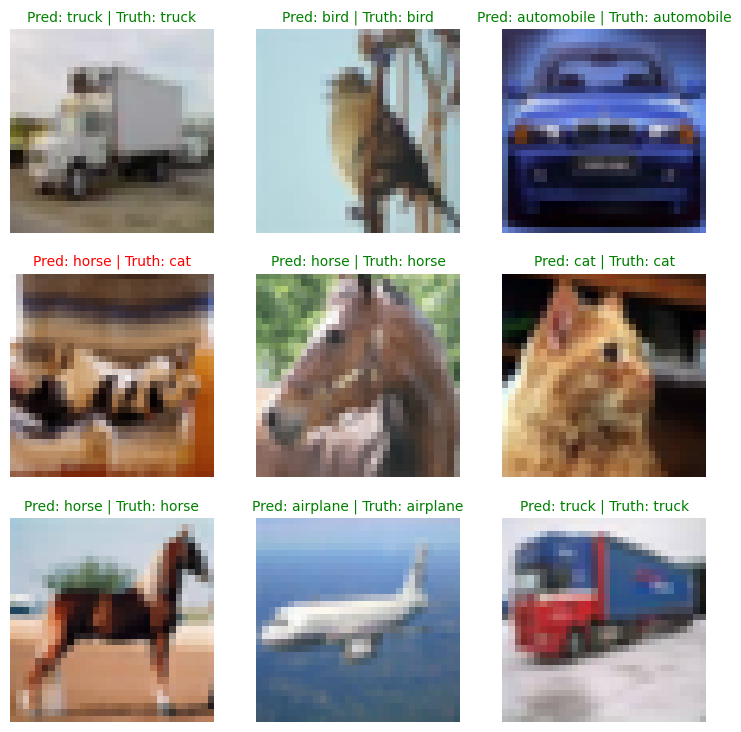

In [48]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows,ncols,i+1)

    # img = Image.open(sample)
    # img = cv2.imread(sample,"Image")


    plt.imshow((sample.squeeze()).permute(1,2,0))

    pred_label = class_names[pred_classes[i]]

    truth_label = class_names[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text,fontsize = 10,c="g")

    else:
        plt.title(title_text,fontsize=10,c="r")

    plt.axis(False);